# QR-DQN + ICM on Unity Pyramids

#### **Main change:** 2 buffers, N-step for QR-DQN, one-step for curiosity

Required installation includes:
* install Unity
* install all Unity API libraries: ml-agents, ml-agents-envs, gym-unity
* build an executable for Pyramids example
* fix "number of agents changed!" issue: assertion is removed (by some reason, 32 agents instead of 16 are returned on dones)

In [1]:
from gym_unity.envs import UnityEnv

In [2]:
# Loading LegoRL library
import sys
sys.path.append('..\\LegoRL')  # path to folder with library

from LegoRL import *

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
import gym

# Environment

In [4]:
env = UnityEnv("./Pyramids/Unity Environment.exe",
                 worker_id=0,                   # ?!?
                 flatten_branched=True,         # returns Discrete action space instead of trivial MultiDiscrete
                 use_visual=False,              # use raycasts as observations instead of pictures
                 multiagent=True,               # there are 16 parallel agents in the Unity scene
                 no_graphics=False)             # show game window

INFO:mlagents_envs:Connected new brain:
Pyramids?team=0
INFO:gym_unity:16 agents within environment.


In [5]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(172,)
Action space: Discrete(5)


In [6]:
# kludge to imitate Vectorized Environment from OpenAI codebase
# and fight some Unity inner demons...

class VEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.num_envs = 16
        
        self.button = np.zeros((16,))
        self.T = np.zeros((16,))
        
    def step(self, a):
        # Unity wants list as actions
        a = a.tolist()
        
        # Step!
        s, r, done, info = self.env.step(a) 
        
        # Unity dev has weird issues
        if len(r) != 16: raise Exception("WTF?")
        
        # We prefer numpy
        s = np.array(s)
        r = np.array(r)
        done = np.array(done)
        
        # Unity last tick bug!
        self.T += 1
        r += (r == 0) * (self.T < 1000)
        self.T[done] = 0
        
        # Storing information about button pushing
        info = [{"button": self.button[i]} for i in range(16)]
        self.button += 1 - s[:, -4]
        self.button[done] = 0
        
        return s, r, done, info
    
    def reset(self):
        # helpers
        self.button = np.zeros((16,))
        self.T = np.zeros((16,))
        
        # We prefer numpy
        s = self.env.reset()
        return np.array(s)
    
env = VEnv(env)

# Network

In [7]:
PyramidsNetwork = lambda input_size, output_size: nn.Sequential(
    nn.Linear(input_size, 150),
    nn.ReLU(),
    nn.Linear(150, 100),
    nn.ReLU(),
    nn.Linear(100, output_size)
)

# ICM

### Feature Extractor (filter)

In [8]:
PyramidsFilter = lambda input_size, output_size: nn.Sequential(
    nn.Linear(input_size, 100),
    nn.ReLU(),
    nn.Linear(100, output_size),
    nn.Tanh()
)

### Dynamics Models

In [9]:
PyramidsInverse = lambda input_size, output_size: nn.Sequential(
            nn.Linear(input_size, 100),
            nn.ReLU(),
            nn.Linear(100, output_size)
        )

In [10]:
PyramidsForward = lambda input_size, output_size: nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )

# Model

In [11]:
QR_DQN = lambda runner: Composed(
    q_head          = QualityHead(network=PyramidsNetwork, representation=Quantile(Q, num_atoms=51)),
    policy          = eGreedy(greedy_policy="q_head", epsilon_decay=50000),
    latency         = NstepLatency(runner=runner, n_steps=10),
    replay          = ReplayBuffer(runner="latency", capacity=100000),
    sampler         = Sampler(replay="replay"),
    target_head     = Frozen(QualityHead)(source="q_head", timer=1000),
    target          = OneStep(evaluator="target_head"),
    critic_loss     = CriticLoss(sampler="sampler", critic="q_head", target="target"),
    trainer         = Trainer(transformations=["q_head"], losses=["critic_loss"], 
                              optimizer_args={"lr": 0.0001}, clip_gradients=10)
)

In [12]:
ICM = lambda runner: Composed(
    replay        = ReplayBuffer(runner=runner, capacity=100000),
    sampler       = Sampler(replay="replay"),
    state_filter  = Backbone(PyramidsFilter, embedding_size=100),
    inverse       = InverseDynamics(backbone="state_filter", network=PyramidsInverse),
    inverse_loss  = DynamicsLoss(sampler="sampler", model="inverse"),
    forward       = ForwardDynamics(backbone="state_filter", network=PyramidsForward),
    forward_loss  = DynamicsLoss(sampler="sampler", model="forward"),    
    trainer       = Trainer(transformations=["state_filter", "inverse", "forward"], 
                            losses=["inverse_loss", "forward_loss"],
                            weights=[1, 1], 
                            optimizer_args={"lr": 0.0001}, clip_gradients=10)
)

In [13]:
agent = Composed(
    visualizer = Visualizer(timer=300),
    runner     = Runner(policy="dqn.policy", timer=8, env_max_T=1000, log_info=[("button", "time till button push")]),
    motivated  = IntrinsicMotivation(runner="runner", motivations=["icm.forward"], coeffs=[0.01]),
    dqn        = QR_DQN(runner="motivated"),
    icm        = ICM(runner="runner")
)

..\c10/core/TensorImpl.h:864: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable.


In [14]:
agent

<visualizer>: Plots logs every 300 iteration
<runner>: Makes one step in 1 parallel environments each 8 iteration using <dqn.policy> policy
<motivated>: Adds intrinsic rewards from <['icm.forward']> with weights [0.01] to stream from <runner>
<dqn>:
    <q_head>: Head, modeling Q-function in quantile form with 51 atoms
    <policy>: Acts randomly with eps-probability, otherwise calls <q_head>
    <latency>: Substitutes stream from <motivated> to 10-step transitions
    <replay>: Stores observations from <latency>
    <sampler>: Samples mini-batches from <replay>
    <target_head>: Copy of <q_head>, updated each 1000 iteration
    <target>: Calculates one-step TD target using <target_head> as next state estimator
    <critic_loss>: Calculates TD loss for <q_head> using <target> as target calculator and data from <sampler>
    <trainer>: Trains <q_head> using following losses: <critic_loss>
    
<icm>:
    <replay>: Stores observations from <runner>
    <sampler>: Samples mini-batches fr

# Initialization issues

In [15]:
system = System(agent, gamma=0.999, folder_name="Models/Pyramids 10-step QR_DQN ICM take2", save_timer=5000, env=env, already_vectorized=True)

Initializing <dqn.q_head>:
  Input shape is torch.Size([172])
  Output shape is torch.Size([51, 5])
Initializing <dqn.target_head>:
  Input shape is torch.Size([172])
  Output shape is torch.Size([5])
Initializing <icm.state_filter>:
  Input shape is torch.Size([172])
  Output shape is torch.Size([100])
Initializing <icm.inverse>:
  Input shape is torch.Size([200])
  Output shape is torch.Size([5])
Initializing <icm.forward>:
  Input shape is torch.Size([105])
  Output shape is torch.Size([100])


# LOAD

In [16]:
# loading model from backup
#system.load()

In [17]:
# some issues during training, had to reload :(
#system.reload_messages

# RUN

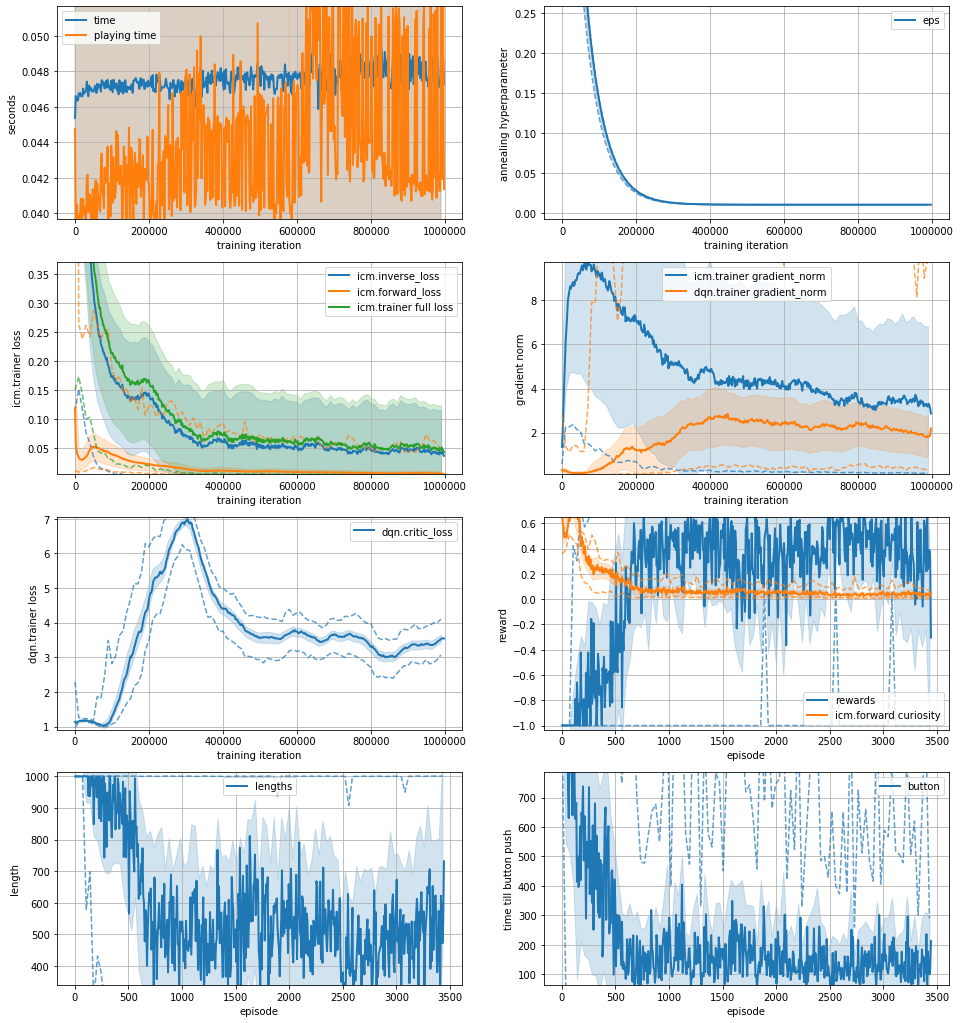

In [18]:
system.run(1000000)

In [19]:
system.save()

# Training statistics

In [20]:
print("Learning time in hours: ", sum(system.logger['time']) / 60 / 60)
print("Viz time in hours: ", sum(system.logger['visualization time']) / 60 / 60)
print("Frames done: ", agent.runner.frames_done)
print("Fps: ", agent.runner.frames_done / sum(system.logger['time']))
print("Episodes played: ", agent.runner.episodes_done)

Learning time in hours:  13.226582929094633
Viz time in hours:  4.184140307307243
Frames done:  2000000
Fps:  42.00295409130162
Episodes played:  3448


Text(0.5, 0, 'episode')

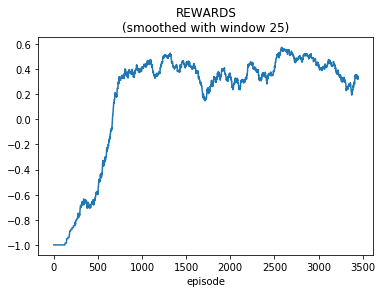

In [21]:
from LegoRL.utils.visualizer import sliding_average
plt.plot(sliding_average(system.logger['rewards'], 100))
plt.title("REWARDS\n(smoothed with window 25)")
plt.xlabel("episode")